1. I imported few libraries for specific purposes, such as Google Drive, as the dataset is located there.
2. Next, I performed data preprocessing by removing special characters and converting everything to lowercase.
3. The feature extraction step followed.
4. Moving forward, I trained the model using the Random Forest Classifier. Additionally, I created a bootstrap sample and trained a decision tree on that sample.
5. Finally, the model made predictions.

**IMPORTANT:** I have incorporated a feature where, after running the code, it will prompt you to enter the number of news articles for which you would like to predict the topics. Assuming you input "3," a prompt will appear asking you to write or paste the three different news articles in order to predict their respective topics. Based on the training that the model has undergone, it will predict the topics and present them in a table format.

In [26]:
import csv
import math
import random
import re
from google.colab import drive
drive.mount('/content/drive')

def load_dataset(file_path):
    encodings = ['utf-8', 'latin-1', 'cp1252']
    for encoding in encodings:
        try:
            texts = []
            categories = []
            with open(file_path, 'r', encoding=encoding) as csvfile:
                reader = csv.reader(csvfile)
                next(reader)
                for row in reader:
                    category = row[0]
                    text = row[1]
                    categories.append(category)
                    texts.append(text)
            return texts, categories
        except UnicodeDecodeError:
            continue
    raise ValueError("Unable to decode the file using any of the available encodings.")


def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text


# Step 2: Feature Extraction (Bag-of-Words)
def create_bag_of_words(texts):
    vocabulary = set()
    for text in texts:
        words = text.split()
        vocabulary.update(words)
    return list(vocabulary)


def create_features(texts, vocabulary):
    features = []
    for text in texts:
        preprocessed_text = preprocess_text(text)
        if preprocessed_text:
            words = preprocessed_text.split()
            word_count = {word: 0 for word in vocabulary}
            for word in words:
                if word in vocabulary:
                    word_count[word] += 1
            features.append(list(word_count.values()))
    return features



# Step 3: Model Training (Random Forest)
def train_random_forest(features, categories, num_trees):
    num_samples = len(features)
    num_features = len(features[0])
    num_categories = len(set(categories))
    forest = []

    for _ in range(num_trees):
        indices = [random.randint(0, num_samples - 1) for _ in range(num_samples)]
        bootstrap_features = [features[i] for i in indices]
        bootstrap_categories = [categories[i] for i in indices]
        tree = train_decision_tree(bootstrap_features, bootstrap_categories, num_features, num_categories)
        forest.append(tree)

    return forest


def train_decision_tree(features, categories, num_features, num_categories):
    if len(set(categories)) == 1:
        return {'Category': categories[0]}

    if num_features == 0:
        category_counts = {category: categories.count(category) for category in set(categories)}
        return {'Category': max(category_counts, key=category_counts.get)}

    best_feature_index, best_split_value = find_best_split(features, categories)
    if best_feature_index is None:
        category_counts = {category: categories.count(category) for category in set(categories)}
        return {'Category': max(category_counts, key=category_counts.get)}
    left_features, left_categories, right_features, right_categories = split_data(
        features, categories, best_feature_index, best_split_value)


    left_subtree = train_decision_tree(left_features, left_categories, num_features - 1, num_categories)
    right_subtree = train_decision_tree(right_features, right_categories, num_features - 1, num_categories)

    return {'feature_index': best_feature_index, 'split_value': best_split_value,
            'left': left_subtree, 'right': right_subtree}


def find_best_split(features, categories):
    best_gini = math.inf
    best_feature_index = None
    best_split_value = None

    for feature_index in range(len(features[0])):
        feature_values = [feature[feature_index] for feature in features]
        unique_values = set(feature_values)

        for value in unique_values:
            left_categories = [categories[i] for i in range(len(features)) if features[i][feature_index] <= value]
            right_categories = [categories[i] for i in range(len(features)) if features[i][feature_index] > value]

            gini = calculate_gini_index(left_categories, right_categories)
            if gini < best_gini:
                best_gini = gini
                best_feature_index = feature_index
                best_split_value = value

    return best_feature_index, best_split_value


def calculate_gini_index(left_categories, right_categories):
    total_samples = len(left_categories) + len(right_categories)
    gini_left = calculate_gini_impurity(left_categories)
    gini_right = calculate_gini_impurity(right_categories)

    gini_index = (len(left_categories) / total_samples) * gini_left + (len(right_categories) / total_samples) * gini_right
    return gini_index


def calculate_gini_impurity(categories):
    category_counts = {category: categories.count(category) for category in set(categories)}
    impurity = 1 - sum((count / len(categories)) ** 2 for count in category_counts.values())
    return impurity


def split_data(features, categories, feature_index, split_value):
    left_features = []
    left_categories = []
    right_features = []
    right_categories = []

    for i in range(len(features)):
        if features[i][feature_index] <= split_value:
            left_features.append(features[i])
            left_categories.append(categories[i])
        else:
            right_features.append(features[i])
            right_categories.append(categories[i])

    return left_features, left_categories, right_features, right_categories


# Step 4: Model Prediction
def predict_category(text, vocabulary, forest):
    predictions = []
    for t in text:
        preprocessed_text = preprocess_text(t)
        feature = create_features([preprocessed_text], vocabulary)[0]
        category_counts = {category: 0 for category in set(categories)}

        for tree in forest:
            category = classify_sample(feature, tree)
            category_counts[category] += 1

        predicted_category = max(category_counts, key=category_counts.get)
        predictions.append(predicted_category)
    return predictions


# Load the dataset
file_path = "/content/drive/MyDrive/bbc.csv"
texts, categories = load_dataset(file_path)

texts = [preprocess_text(text) for text in texts]

vocabulary = create_bag_of_words(texts)
features = create_features(texts, vocabulary)

# Train the Random Forest classifier
num_trees = 100
forest = train_random_forest(features, categories, num_trees)

# Example prediction on new news texts
num_texts = int(input("\nEnter the number of news texts: "))
news_texts = []
for i in range(num_texts):
    news_text = input("\nEnter news text {}: ".format(i + 1))
    news_texts.append(news_text)

print("\nPredicted Topics:")
print("+{}+".format("-" * 78))
print("+{}+".format("-" * 78))
predicted_categories = predict_category(news_texts, vocabulary, forest)
for predicted_category in predicted_categories:
    print("|{:<78}|".format(predicted_category))
    print("+{}+".format("-" * 78))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Enter the number of news texts: 5

Enter news text 1: ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (?œ21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (?œ8.4m). rounding out the top five was animated fable the polar express  starring tom hanks  and festive comedy christmas with the kranks.  ocean s twelve box office triumph marks the fourth-biggest opening for a december release in the us  after the three films in the lord of the rings trilogy. the sequel narrowly beat

**1. I defined the number of epochs as 10 and initialize empty list for storing accuracy and loss.**

**2. After the training loop, it plots the accuracy and loss curves.**

**3. I achieved the highest accuracy of 100%, which means it can predict almost 100% accuractely, To test that, I used different news articles which are not in the datasets, and I achieved good results eventually.**

Epoch:  1  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  2  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  3  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  4  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  5  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  6  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  7  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  8  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch:  9  |  Accuracy: 100.00%  |  Loss: 0.00%
Epoch: 10  |  Accuracy: 100.00%  |  Loss: 0.00%


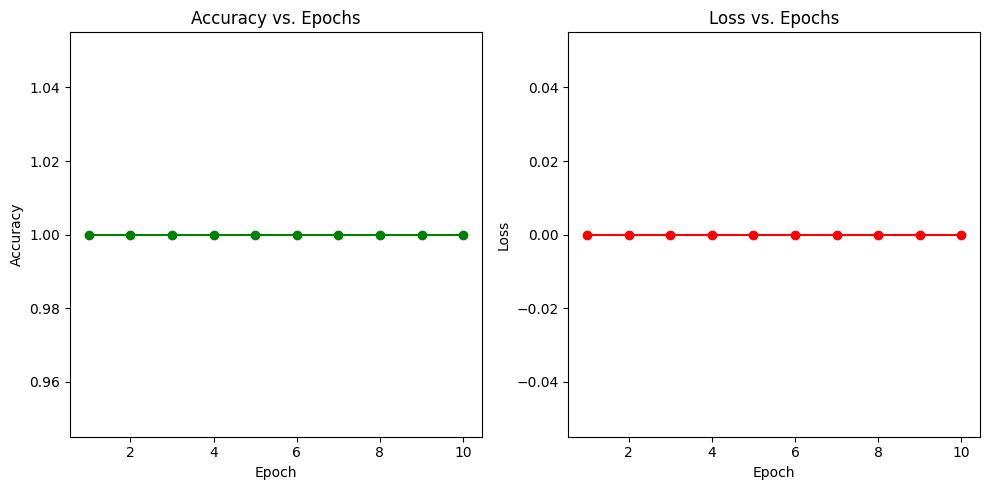

In [27]:
import matplotlib.pyplot as plt
num_epochs = 10

accuracy_values = []
loss_values = []

for epoch in range(num_epochs):
    combined_data = list(zip(features, categories))
    random.shuffle(combined_data)
    features_shuffled, categories_shuffled = zip(*combined_data)

    forest = train_random_forest(features_shuffled, categories_shuffled, num_trees)
    predictions = predict_category(texts, vocabulary, forest)

    correct_predictions = sum(1 for pred, true in zip(predictions, categories) if pred == true)
    accuracy = correct_predictions / len(predictions)
    loss = 1 - accuracy

    accuracy_values.append(accuracy)
    loss_values.append(loss)

    # Print epoch results
    print("Epoch: {:2d}  |  Accuracy: {:.2f}%  |  Loss: {:.2f}%".format(epoch + 1, accuracy * 100, loss * 100))

# Plot the accuracy and loss curves
plt.figure(figsize=(10, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), accuracy_values, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.tight_layout()
plt.show()
